# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

Please make sure if you are running this notebook in the workspace that you have chosen GPU rather than CPU mode.

In [12]:
# Imports here
%matplotlib inline 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
from torch import optim
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models

from collections import OrderedDict

use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.RandomRotation(15),
                                       transforms.RandomResizedCrop(220),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])
#can resize and crop (don't rotate)
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])


train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)
valid_dataset = datasets.ImageFolder(valid_dir, transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=32)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=32)

# TODO: Define your transforms for the training, validation, and testing sets
#data_transforms = {'train_transforms':train_transforms, 'test_trainsforms':test_transforms}
# TODO: Load the datasets with ImageFolder
#image_datasets = {'train_datasets':train_datasets,'test_datasets':test_datasets}
# TODO: Using the image datasets and the trainforms, define the dataloaders
#dataloaders = {'trainloaders':trainloaders,'testloaders':testloaders}


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
import json
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
n_class = len(cat_to_name)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

In [12]:
# TODO: Build and train your network

#1. load network
model = models.vgg19(pretrained=True)#'imagenet'
#2 define a new untrained feed-forward network as classifier
class_in = model.classifier[0].in_features
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(class_in, 512)),
                          ('relu', nn.ReLU()),
                          ('dropout', nn.Dropout(p=0.5)),
                          ('fc2', nn.Linear(512, n_class)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.005, momentum = 0.5)

#optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9, nesterov=True)
#optimizer = optim.SGD(filter(lambda p: p.requires_grad,model.parameters()), lr=0.01)
#model.compile(optimizer=sgd, loss='categorical_crossentropy')

In [13]:
#define training function
def training(model,trainloader,epochs,criterion,optimizer): 
    for epoch in range(epochs):
        print('epoch:{}/{}-----'.format(epoch,epochs)) #not iter
        model.train()
        running_loss, running_accuracy = 0,0
        step = 0
        for inputs,labels in iter(trainloader):
                      
            if(step%20==0):
                print('step:{}/{}-----'.format(step+1,len(trainloader.dataset))) #not iter
            step += 1  
            inputs,labels = inputs.to(device),labels.to(device)
            optimizer.zero_grad()             
            outputs = model.forward(inputs)
            _, preds = torch.max(outputs,1)
            loss = criterion(outputs,labels)             
            loss.backward()
            optimizer.step()
            
            running_loss+=loss.item()*inputs.size(0)
            equal = labels.data==outputs.max(dim=1)[1]
            running_accuracy += torch.sum(equal)
        
        running_accuracy = running_accuracy.double()
        print('Training Loss: {:.4f}'.format((running_loss/len(trainloader.dataset))),
                      'Training Accuracy: {:.4f}'.format((running_accuracy.double()/len(trainloader.dataset))))
        model.eval()
        with torch.no_grad():
            valid_loss,valid_accuracy = validation(model,validloader,criterion)
            print('Validation Loss: {:.4f}-----'.format(valid_loss),
                          'Validation Accuracy: {:.4f}'.format(valid_accuracy))

#define validation function
def validation(model,validloader,criterion):
    valid_loss, valid_accuracy=0,0
    model = model.to(device)
     
    for inputs,labels in iter(validloader):        
        inputs,labels = inputs.to(device),labels.to(device)
        output = model.forward(inputs)
        equal = (labels.data==output.max(dim=1)[1])
        valid_loss += criterion(output,labels).item()*inputs.size(0)
        valid_accuracy += torch.sum(equal)

    step_loss = valid_loss / len(validloader.dataset)
    step_acc = valid_accuracy.double() / len(validloader.dataset)  
    
    return step_loss, step_acc

In [ ]:
epochs = 10
training(model,trainloader,epochs,criterion,optimizer)

103
6552
STEP NOW
0
STEP
0
STEP
1
STEP
2
STEP
3
STEP
4
STEP
5
STEP
6
STEP
7
STEP
8
STEP
9
STEP
10
STEP
11
STEP
12
STEP
13
STEP
14
STEP
15
STEP
16
STEP
17
STEP
18
STEP
19
STEP
20
STEP
21
STEP
22
STEP
23
STEP
24
STEP
25
STEP
26
STEP
27
STEP
28
STEP
29
STEP
30
STEP
31
STEP
32
STEP
33
STEP
34
STEP
35
STEP
36
STEP
37
STEP
38
STEP
39
STEP
40
STEP
41
STEP
42
STEP
43
STEP
44
STEP
45
STEP
46
STEP
47
STEP
48
STEP
49
STEP
50
STEP
51
STEP
52
STEP
53
STEP
54
STEP
55
STEP
56
STEP
57
STEP
58
STEP
59
STEP
60
STEP
61
STEP
62
STEP
63
STEP
64
STEP
65
STEP
66
STEP
67
STEP
68
STEP
69
STEP
70
STEP
71
STEP
72
STEP
73
STEP
74
STEP
75
STEP
76
STEP
77
STEP
78
STEP
79
STEP
80
STEP
81
STEP
82
STEP
83
STEP
84
STEP
85
STEP
86
STEP
87
STEP
88
STEP
89
STEP
90
STEP
91
STEP
92
STEP
93
STEP
94
STEP
95
STEP
96
STEP
97
STEP
98
STEP
99
STEP
100
STEP
101
STEP
102
epoch:0/10-----
Training Loss: 0.9096 Training Accuracy: 0.7582
Validation Loss: 0.3372----- Validation Accuracy: 0.9181
STEP NOW
1
STEP
0
STEP
1
STEP
2
STEP
3
STE

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [16]:
# TODO: Do testing
model.eval()

total,correct,step = 0,0,0

for images,labels in iter(testloader):
    image,label = images.to(device), labels.to(device)
    with torch.no_grad(): #no need for grad
        step += 1
        output = model.forward(image)
        ps = torch.exp(output) #actual prob
        _, predicted = torch.max(output.data,1)
        total += label.size(0)
        correct += (predicted == label).sum().item() 
        print("SNo {}: Accuracy of network on test images is ... {:.4f}".format(step, correct/total))

SNo 1: Accuracy of network on test images is ... 1.0000
SNo 2: Accuracy of network on test images is ... 1.0000
SNo 3: Accuracy of network on test images is ... 0.9896
SNo 4: Accuracy of network on test images is ... 0.9688
SNo 5: Accuracy of network on test images is ... 0.9437
SNo 6: Accuracy of network on test images is ... 0.9531
SNo 7: Accuracy of network on test images is ... 0.9286
SNo 8: Accuracy of network on test images is ... 0.9297
SNo 9: Accuracy of network on test images is ... 0.9375
SNo 10: Accuracy of network on test images is ... 0.9437
SNo 11: Accuracy of network on test images is ... 0.9432
SNo 12: Accuracy of network on test images is ... 0.9479
SNo 13: Accuracy of network on test images is ... 0.9447
SNo 14: Accuracy of network on test images is ... 0.9487
SNo 15: Accuracy of network on test images is ... 0.9500
SNo 16: Accuracy of network on test images is ... 0.9531
SNo 17: Accuracy of network on test images is ... 0.9540
SNo 18: Accuracy of network on test imag

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [ ]:
# TODO: Save the checkpoint 

model.class_to_idx=train_dataset.class_to_idx #class to index mapping
#size,index, classifier, state_dict
checkpoint={'input_size':class_in, 
            'output_size':n_class,
            'class_to_index':model.class_to_idx,
            'classifier':model.classifier,
            'state_dict':model.state_dict(),
            'epochs':epochs
           }
torch.save(checkpoint,'Checkpoint_1.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [15]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
filepath = 'Checkpoint_1.pth'
checkpoint = ""
if(device==torch.device('cuda:0')):
    print("USING CUDA")
    checkpoint= torch.load(filepath)
else:
    checkpoint= torch.load(filepath,map_location=lambda storage,loc:storage)  
load_model= models.vgg19(pretrained=True)#'(pretrained=True) 
load_model.class_to_idx=checkpoint['class_to_index'] #classes to index
load_model.classifier=checkpoint['classifier']
load_model.load_state_dict(checkpoint['state_dict'])


USING CUDA


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [16]:
from PIL import Image, ImageOps

def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    im2 = Image.open(image)
    im = im2
    new_height = 256
    new_width  = new_height * im.width // im.height
    im = im.resize((new_width, new_height), Image.ANTIALIAS)
    im = ImageOps.fit(im,(224,224),centering=(0.5, 0.5))
    np_image = np.array(im)
    np_image = (np_image - np.mean(np_image))/np.std(np_image)
    np_image = np_image.transpose((2, 0,1))
    return np_image

np_image = process_image('flowers/train/1/image_06737.jpg')

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

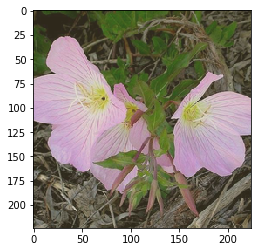

In [17]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)    
    ax.imshow(image)
    return ax

imshow(np_image)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [18]:
def predict(image_path, model, topK=5):
    criterion = nn.CrossEntropyLoss()
    np_image = process_image(image_path)
    
    img = torch.from_numpy(np_image).float().to(device)
    img.unsqueeze_(0) 
    model.to(device)
    model.eval()
    with torch.no_grad():
        output = model.forward(img)
    #ps = F.softmax(output,dim=1)
    ps = torch.exp(output) #actual prob
    answer = ps.topk(topK) 
    probs = answer[0]
    classes = answer[1]
    return probs,classes
        

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

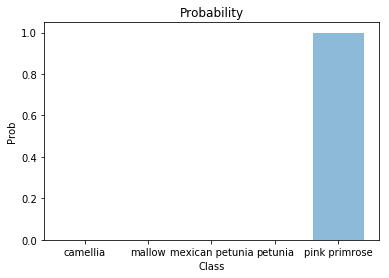

In [19]:
# TODO: Display an image along with the top 5 classes

filepath = 'flowers/train/1/image_06734.jpg'

topk = 5
preds,classes = predict(filepath,load_model,topk)

classes = np.array(classes)
preds = np.array(preds)

inv_map = {v: k for k, v in load_model.class_to_idx.items()}
x,y = [],[]
for i in range(topk):
    k = str(inv_map[classes[0][i]])
    x.append(cat_to_name[k])
    y.append(preds[0][i])

plt.bar(x,y, align='center', alpha=0.5)
plt.ylabel('Prob')
plt.xlabel('Class')
plt.title('Probability')
plt.show()        